______________
Importing necessary libraries and setting global variables

In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
from scipy.stats import mode
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import StandardScaler
from models import UnbalancedBagger, UnbalancedBaggerNoSampling
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve
import math
from statsmodels.stats.contingency_tables import mcnemar

RANDOM_SEED = 12345

In [130]:
original_df = pd.read_csv("datasets/diabetes.csv")


In [131]:
original_df.describe()
#weird that "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI" have zero values, imputate mean values

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [132]:
print("Amount of 0 values:")
print("Glucose: ", len(original_df[original_df["Glucose"] == 0]))
print("BloodPressure: ", len(original_df[original_df["BloodPressure"] == 0]))
print("SkinThickness: ", len(original_df[original_df["SkinThickness"] == 0]))
print("Insulin: ", len(original_df[original_df["Insulin"] == 0]))
print("BMI: ", len(original_df[original_df["BMI"] == 0]))

Amount of 0 values:
Glucose:  5
BloodPressure:  35
SkinThickness:  227
Insulin:  374
BMI:  11


In [133]:
def imputation(data, columns):
    for c in columns:
         if c in data.columns:
             data[c].replace(0, np.nan,inplace=True)
             data[c].fillna(data[c].mean(), inplace=True)
    return data


In [134]:
original_df = imputation(original_df, ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"])

original_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.435949,12.096346,8.790942,85.021108,6.875151,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.202592,29.153420,155.548223,32.400000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,155.548223,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


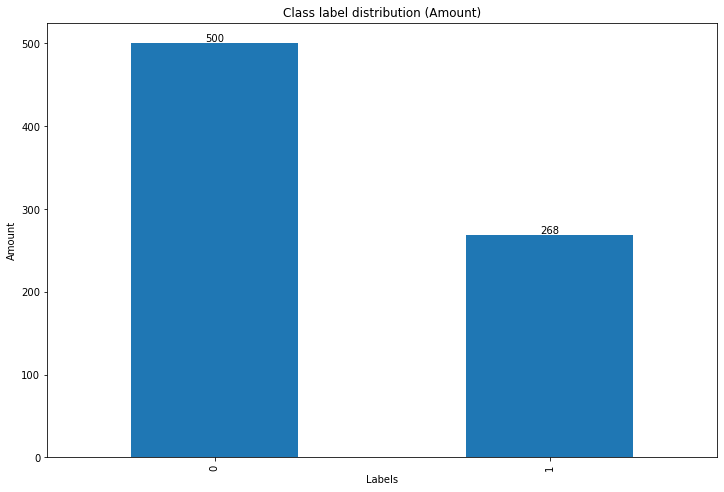

In [135]:
total_labels = original_df.Outcome.value_counts()
x_labels = [0,1]

plt.figure(figsize=(12,8))
ax = total_labels.plot(kind='bar')
ax.set_title('Class label distribution (Amount)')
ax.set_xlabel('Labels')
ax.set_ylabel('Amount')
ax.set_xticklabels(x_labels)

rects = ax.patches

for rect,lbl in zip(rects, total_labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height
            , lbl, ha='center', va='bottom')

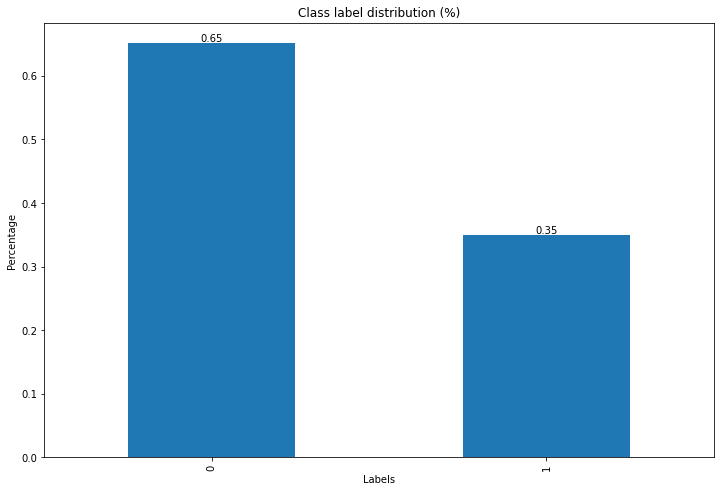

In [136]:
x_labels = [0,1]
total_labels_percentage = original_df.Outcome.value_counts()/len(original_df)

plt.figure(figsize=(12,8))
ax = total_labels_percentage.plot(kind='bar')
ax.set_title('Class label distribution (%)')
ax.set_xlabel('Labels')
ax.set_ylabel('Percentage')
ax.set_xticklabels(x_labels)

rects = ax.patches
labels = []

for lbl in total_labels_percentage:
    labels.append("{0:.2f}".format(lbl))

for rect,lbl in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height
            , lbl, ha='center', va='bottom')

In [137]:
#we can now split attributes and class label
X = original_df.drop('Outcome', axis=1)
y = original_df.Outcome

X.describe()

#data_standardized used for SVC
scaler = StandardScaler()
data_standardized = scaler.fit_transform(X)
data_standardized = pd.DataFrame(data_standardized,columns=X.columns)

In [138]:
X_train,X_test,y_train,y_test, = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

#standardized split for SVC
X_train_svc,X_test_svc,y_train_svc,y_test_svc, = train_test_split(data_standardized, y, test_size=0.3, random_state=RANDOM_SEED)

In [139]:
param_grid_svc = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf', 'poly']},
 ]

param_grid_dt = [
    {'splitter' : ['best', 'random'],
     'min_samples_split':[2,5,10],
     'min_samples_leaf':[1,5,10],
     'min_weight_fraction_leaf':[0,0.05, 0.1, 0.15, 0.2]
     }
]

dtc = DecisionTreeClassifier(random_state=RANDOM_SEED)
svc = SVC(random_state=RANDOM_SEED, probability=True)

#Methods for sampling
ros = RandomOverSampler(random_state=RANDOM_SEED)
rus = RandomUnderSampler(random_state=RANDOM_SEED)
smote = SMOTE(random_state=RANDOM_SEED, sampling_strategy='minority')

#scoring was before roc_auc, now:
search_dtc = GridSearchCV(dtc, param_grid_dt, cv=10, scoring='average_precision')
search_svc = GridSearchCV(svc, param_grid_svc, cv=10, scoring='average_precision')

list_of_auc = []
list_of_auprc = []
list_of_pos_probs = []
list_of_avg_prec = []
list_of_mcnemar_results = []

In [140]:
def smote_technique(X,y):
    x_sample, y_sample = smote.fit_sample(X, y)
    return x_sample,y_sample

def random_oversampling_technique(X,y):
    x_sample, y_sample = ros.fit_sample(X, y)
    return x_sample,y_sample

def random_undersampling_technique(X,y):
    x_sample, y_sample = rus.fit_sample(X, y)
    return x_sample,y_sample

In [141]:
def create_AUPRC_values(classifier, X_test, y_true):
    probs = classifier.predict_proba(X_test)
    pos_probs = probs[:,1]
    prec,recall,_ = precision_recall_curve(y_true, pos_probs)
    avg_prec = average_precision_score(y_true, probs)
    return prec,recall,avg_prec

In [142]:
def create_AUPRC_curves(list_of_rpl):
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    for recall, prec, lbl in list_of_rpl:
        plt.plot(recall,prec,marker='.', label=lbl)
        plt.legend()

In [143]:
def get_AUC_plot_values(model, X, y, label):
    score = roc_auc_score(y,model.predict(X))
    #return [label + "{0:.2f}".format(score), score]
    return [label, score]

In [144]:
def get_AUPRC_values(model, X, y, label):
    probs = model.predict_proba(X)
    pos_probs = probs[:,1]
    #list_of_pos_probs.append(pos_probs,label)
    prec,recall,_ = precision_recall_curve(y, pos_probs)
    avg_prec = average_precision_score(y, pos_probs)
    return [prec,recall,label], [avg_prec, label]

In [145]:
def create_AUC_bars(list_of_auc):
    #list of auc: [label, värde]
    xlabels, scores = zip(*list_of_auc)
    xs = np.arange(len(xlabels))

    plt.bar(xs,scores,align='center')
    plt.xticks(xs, xlabels, rotation='vertical')
    plt.ylabel("AUC Score")

    labels = []
    for lbl in scores:
        labels.append("{0:.2f}".format(lbl))

    for index, value in enumerate(labels):
        plt.text(value, index, labels)

In [146]:
def calculate_cont_table(model_one_preds, model_two_preds, true_preds):
    both_correct, model1_correct, model2_correct, non_correct = 0,0,0,0
    for idx in range(len(true_preds)):
        if model_one_preds[idx] == true_preds[idx]:
            if model_two_preds[idx] == true_preds[idx]:
                both_correct = both_correct + 1
            else:
                model1_correct = model1_correct + 1
        elif model_two_preds[idx] == true_preds[idx]:
            model2_correct = model2_correct + 1
        else:
            non_correct = non_correct + 1
    return [[both_correct,model1_correct],[model2_correct,non_correct]]

In [147]:
def calculate_mcneamar(table):
    result = mcnemar(table, exact=False, correction=True)
    return result.statistic, result.pvalue

In [148]:
#new method, using smote, ros, rus
sampling_techniques = [smote, ros, rus]
svc = SVC(C=1000, gamma=0.001, random_state=12345, probability=True)
dtc = DecisionTreeClassifier(min_samples_leaf=10, min_weight_fraction_leaf=0,random_state=12345)

dt_predict, dt_proba = UnbalancedBagger.unbalanced_bagger(X_train, y_train, 10, sampling_techniques,base_estimator=dtc,random_seed=RANDOM_SEED)
svc_predict, svc_proba = UnbalancedBagger.unbalanced_bagger(X_train_svc, y_train_svc, 10, sampling_techniques,base_estimator=svc,random_seed=RANDOM_SEED)

predictions_dt_unb = dt_predict(X_test)
predictions_svc_unb = svc_predict(X_test_svc)

score_dt = roc_auc_score(y_test,predictions_dt_unb)
score_svc = roc_auc_score(y_test_svc,predictions_svc_unb)

#list_of_auc.append(['Unb_bagging, DT' + "{0:.2f}".format(score_dt),score_dt])
#list_of_auc.append(['Unb_bagging, SVC' + "{0:.2f}".format(score_dt),score_svc])
list_of_auc.append(['Unb_bagging, DT',score_dt])
list_of_auc.append(['Unb_bagging, SVC',score_svc])

probs_dt = dt_proba(X_test)
pos_probs = probs_dt[:,1]
prec,recall,_ = precision_recall_curve(y_test,pos_probs)
#
avg_prec = average_precision_score(y_test, pos_probs)
list_of_avg_prec.append([avg_prec, 'Unb_bagging, DT'])
#
list_of_auprc.append([prec,recall,'Unb_bagging, DT'])

probs_svc = svc_proba(X_test_svc)
pos_probs = probs_svc[:,1]
prec,recall,_ = precision_recall_curve(y_test_svc,pos_probs)
#
avg_prec = average_precision_score(y_test_svc, pos_probs)
list_of_avg_prec.append([avg_prec, 'Unb_bagging, SVC'])
#
list_of_auprc.append([prec,recall,'Unb_bagging, SVC'])

In [149]:
#Train on original data
dt_classifier = search_dtc.fit(X_train, y_train).best_estimator_
svc_classifier = search_svc.fit(X_train_svc, y_train_svc).best_estimator_

In [150]:
list_of_auc.append(get_AUC_plot_values(dt_classifier, X_test,y_test, 'Original,DT'))
list_of_auc.append(get_AUC_plot_values(svc_classifier, X_test_svc,y_test_svc, 'Original,SVC'))

auprc, avg_prec = get_AUPRC_values(dt_classifier,X_test, y_test, 'Original,DT')
list_of_auprc.append(auprc)
list_of_avg_prec.append(avg_prec)

auprc, avg_prec = get_AUPRC_values(svc_classifier, X_test_svc, y_test_svc, 'Original,SVC')
list_of_auprc.append(auprc)
list_of_avg_prec.append(avg_prec)
#list_of_auprc.append(get_AUPRC_values(dt_classifier,X_test, y_test, 'Orig,DT'))
#list_of_auprc.append((get_AUPRC_values(svc_classifier, X_test_svc, y_test_svc, 'Orig,SVC')))

table = calculate_cont_table(predictions_dt_unb, dt_classifier.predict(X_test), y_test.values)
list_of_mcnemar_results.append(["original_DT", calculate_mcneamar(table)])
table = calculate_cont_table(predictions_svc_unb, svc_classifier.predict(X_test_svc), y_test_svc.values)
list_of_mcnemar_results.append(["Original SVC", calculate_mcneamar(table)])

print("Best DT estimator: ", search_dtc.best_estimator_)
print("Best SVC estimator: ", search_svc.best_estimator_)

Best DT estimator:  DecisionTreeClassifier(min_samples_leaf=10, min_weight_fraction_leaf=0,
                       random_state=12345, splitter='random')
Best SVC estimator:  SVC(C=1000, gamma=0.001, probability=True, random_state=12345)


In [151]:
#Train on SMOTE
sampled_dtc_x, sampled_dtc_y = smote_technique(X_train,y_train)
sampled_svc_x, sampled_svc_y = smote_technique(X_train_svc,y_train_svc)

dt_classifier = search_dtc.fit(sampled_dtc_x, sampled_dtc_y).best_estimator_
svc_classifier = search_svc.fit(sampled_svc_x, sampled_svc_y).best_estimator_

list_of_auc.append(get_AUC_plot_values(dt_classifier, X_test,y_test, 'SMOTE,DT'))
list_of_auc.append(get_AUC_plot_values(svc_classifier, X_test_svc,y_test_svc, 'SMOTE,SVC'))

auprc, avg_prec = get_AUPRC_values(dt_classifier,X_test, y_test, 'SMOTE,DT')
list_of_auprc.append(auprc)
list_of_avg_prec.append(avg_prec)

auprc, avg_prec = get_AUPRC_values(svc_classifier, X_test_svc, y_test_svc, 'SMOTE,SVC')
list_of_auprc.append(auprc)
list_of_avg_prec.append(avg_prec)
#list_of_auprc.append(get_AUPRC_values(dt_classifier,X_test, y_test, 'SMOTE,DT'))
#list_of_auprc.append((get_AUPRC_values(svc_classifier, X_test_svc, y_test_svc, 'SMOTE,SVC')))

table = calculate_cont_table(predictions_dt_unb, dt_classifier.predict(X_test), y_test.values)
list_of_mcnemar_results.append(["SMOTE,DT", calculate_mcneamar(table)])
table = calculate_cont_table(predictions_svc_unb, svc_classifier.predict(X_test_svc), y_test_svc.values)
list_of_mcnemar_results.append(["SMOTE, SVC", calculate_mcneamar(table)])

print("Best DT estimator: ", search_dtc.best_estimator_)
print("Best SVC estimator: ", search_svc.best_estimator_)

Best DT estimator:  DecisionTreeClassifier(min_samples_leaf=10, min_weight_fraction_leaf=0,
                       random_state=12345, splitter='random')
Best SVC estimator:  SVC(C=1000, gamma=0.001, probability=True, random_state=12345)


In [152]:
#Train on random oversampling
sampled_dtc_x, sampled_dtc_y = random_oversampling_technique(X_train,y_train)
sampled_svc_x, sampled_svc_y = random_oversampling_technique(X_train_svc,y_train_svc)

dt_classifier = search_dtc.fit(sampled_dtc_x, sampled_dtc_y)
svc_classifier = search_svc.fit(sampled_svc_x, sampled_svc_y)

list_of_auc.append(get_AUC_plot_values(dt_classifier, X_test,y_test, 'Rand_oversamp,DT'))
list_of_auc.append(get_AUC_plot_values(svc_classifier, X_test_svc,y_test_svc, 'Rand_oversamp,SVC'))

auprc, avg_prec = get_AUPRC_values(dt_classifier,X_test, y_test, 'Rand_oversamp,DT')
list_of_auprc.append(auprc)
list_of_avg_prec.append(avg_prec)

auprc, avg_prec = get_AUPRC_values(svc_classifier, X_test_svc, y_test_svc, 'Rand_oversamp,SVC')
list_of_auprc.append(auprc)
list_of_avg_prec.append(avg_prec)
#list_of_auprc.append(get_AUPRC_values(dt_classifier,X_test, y_test, 'Rand_O,DT'))
#list_of_auprc.append((get_AUPRC_values(svc_classifier, X_test_svc, y_test_svc, 'Rand_O,SVC')))

table = calculate_cont_table(predictions_dt_unb, dt_classifier.predict(X_test), y_test.values)
list_of_mcnemar_results.append(["Rand_Over,DT", calculate_mcneamar(table)])
table = calculate_cont_table(predictions_svc_unb, svc_classifier.predict(X_test_svc), y_test_svc.values)
list_of_mcnemar_results.append(["Rand_Over, SVC", calculate_mcneamar(table)])

print("Best DT estimator: ", search_dtc.best_estimator_)
print("Best SVC estimator: ", search_svc.best_estimator_)

Best DT estimator:  DecisionTreeClassifier(min_samples_leaf=10, min_weight_fraction_leaf=0,
                       random_state=12345)
Best SVC estimator:  SVC(C=1000, gamma=0.001, probability=True, random_state=12345)


In [153]:
#Train on random undersampling
sampled_dtc_x, sampled_dtc_y = random_undersampling_technique(X_train,y_train)
sampled_svc_x, sampled_svc_y = random_undersampling_technique(X_train_svc,y_train_svc)

dt_classifier = search_dtc.fit(sampled_dtc_x, sampled_dtc_y)
svc_classifier = search_svc.fit(sampled_svc_x, sampled_svc_y)

list_of_auc.append(get_AUC_plot_values(dt_classifier, X_test,y_test, 'Rand_undersamp,DT'))
list_of_auc.append(get_AUC_plot_values(svc_classifier, X_test_svc,y_test_svc, 'Rand_undersamp,SVC'))

auprc, avg_prec = get_AUPRC_values(dt_classifier,X_test, y_test, 'Rand_undersamp,DT')
list_of_auprc.append(auprc)
list_of_avg_prec.append(avg_prec)

auprc, avg_prec = get_AUPRC_values(svc_classifier, X_test_svc, y_test_svc, 'Rand_undersamp,SVC')
list_of_auprc.append(auprc)
list_of_avg_prec.append(avg_prec)
#list_of_auprc.append(get_AUPRC_values(dt_classifier,X_test, y_test, 'Rand_U,DT'))
#list_of_auprc.append((get_AUPRC_values(svc_classifier, X_test_svc, y_test_svc, 'Rand_U,SVC')))

table = calculate_cont_table(predictions_dt_unb, dt_classifier.predict(X_test), y_test.values)
list_of_mcnemar_results.append(["Rand_Under,DT", calculate_mcneamar(table)])
table = calculate_cont_table(predictions_svc_unb, svc_classifier.predict(X_test_svc), y_test_svc.values)
list_of_mcnemar_results.append(["Rand_Under, SVC", calculate_mcneamar(table)])

print("Best DT estimator: ", search_dtc.best_estimator_)
print("Best SVC estimator: ", search_svc.best_estimator_)

Best DT estimator:  DecisionTreeClassifier(min_weight_fraction_leaf=0.1, random_state=12345)
Best SVC estimator:  SVC(C=10, gamma=0.001, probability=True, random_state=12345)


In [154]:
#CHANGE, BAGGINBG NO SAMPLING TECHNIQUES
svc = SVC(C=1000, gamma=0.001, random_state=12345, probability=True)
dtc = DecisionTreeClassifier(min_samples_leaf=10, min_weight_fraction_leaf=0,splitter='random',random_state=12345)

dt_predict, dt_proba = UnbalancedBaggerNoSampling.unbalanced_bagger_no_sampling(X_train, y_train, 10,random_seed=RANDOM_SEED)
svc_predict, svc_proba = UnbalancedBaggerNoSampling.unbalanced_bagger_no_sampling(X_train_svc, y_train_svc, 10,random_seed=RANDOM_SEED)

predictions_dt = dt_predict(X_test)
predictions_svc = svc_predict(X_test_svc)

score_dt = roc_auc_score(y_test,predictions_dt)
score_svc = roc_auc_score(y_test_svc,predictions_svc)

#list_of_auc.append(['Unb_bagging, DT' + "{0:.2f}".format(score_dt),score_dt])
#list_of_auc.append(['Unb_bagging, SVC' + "{0:.2f}".format(score_dt),score_svc])
list_of_auc.append(['Bagging, DT',score_dt])
list_of_auc.append(['Bagging, SVC',score_svc])

probs_dt = dt_proba(X_test)
pos_probs = probs_dt[:,1]
prec,recall,_ = precision_recall_curve(y_test,pos_probs)
#
avg_prec = average_precision_score(y_test, pos_probs)
list_of_avg_prec.append([avg_prec, 'Bagging, DT'])
#
list_of_auprc.append([prec,recall,'Bagging, DT'])

probs_svc = svc_proba(X_test_svc)
pos_probs = probs_svc[:,1]
prec,recall,_ = precision_recall_curve(y_test_svc,pos_probs)
#
avg_prec = average_precision_score(y_test_svc, pos_probs)
list_of_avg_prec.append([avg_prec, 'Bagging, SVC'])
#
list_of_auprc.append([prec,recall,'Bagging, SVC'])

table = calculate_cont_table(predictions_dt_unb, predictions_dt, y_test.values)
list_of_mcnemar_results.append(["bagging, DT", calculate_mcneamar(table)])
table = calculate_cont_table(predictions_svc_unb, predictions_svc, y_test_svc.values)
list_of_mcnemar_results.append(["bagging, SVC", calculate_mcneamar(table)])

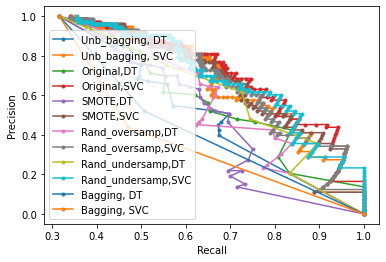

In [155]:
create_AUPRC_curves(list_of_auprc)
plt.show()

In [156]:
def create_AUC_bars_two(list_of_auc):
    x,y = zip(*list_of_auc)
    plt.figure(figsize=(12,8))
    plt.barh(x, y)
    plt.title("AUC values for each model")
    for index, value in enumerate(y):
        plt.text(value, index, str("{0:.2f}".format(value)))

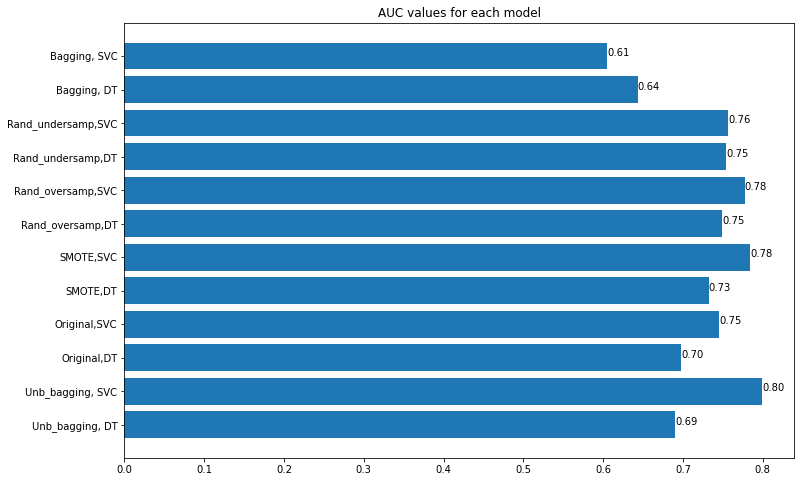

In [157]:
create_AUC_bars_two(list_of_auc)
plt.show()

In [158]:
def create_AUPRC_bars(list_of_avg_prec):
    y, x = zip(*list_of_avg_prec)
    plt.figure(figsize=(12,8))
    plt.barh(x, y)
    plt.title("Average precision values for each model")
    for index, value in enumerate(y):
        plt.text(value, index, str("{0:.2f}".format(value)))

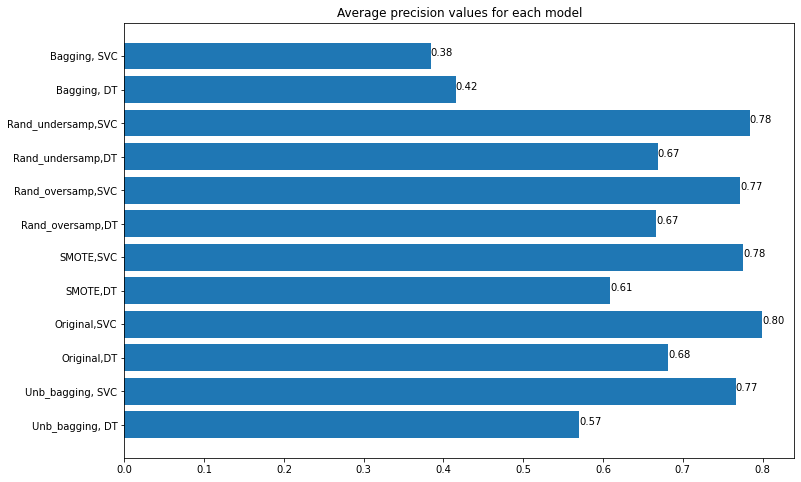

In [159]:
create_AUPRC_bars(list_of_avg_prec)
plt.show()

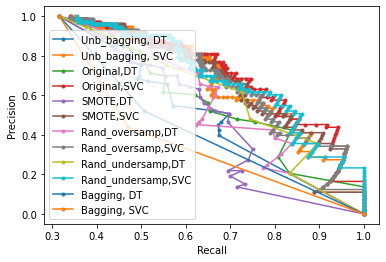

In [160]:
create_AUPRC_curves(list_of_auprc)
plt.show()

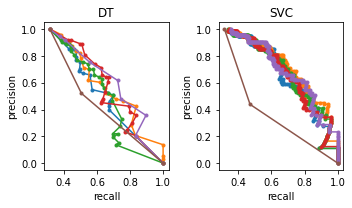

In [161]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
axes[0].set(xlabel="recall")
axes[0].set(ylabel="precision")
axes[1].set(xlabel="recall")
axes[1].set(ylabel="precision")
axes[0].set(title="DT")
axes[1].set(title="SVC")
for recall, prec, lbl in list_of_auprc:
    if "DT" in lbl:
        axes[0].plot(recall,prec,marker='.', label=lbl)
    else:
        axes[1].plot(recall,prec,marker='.', label=lbl)

fig.tight_layout()
plt.show()

In [181]:
def get_mcnemar_df():
    labels = []
    p_values = []
    stats = []
    for label, values in list_of_mcnemar_results:
        labels.append(label)
        stats.append(values[0])
        p_values.append(values[1])
    data = {'Model':labels, 'Statistic':stats, 'p_value':p_values}
    df = pd.DataFrame(data,columns=["Model", "Statistic", "p_value"])
    return df

In [183]:
print(get_mcnemar_df())

             Model  Statistic   p_value
0      original_DT   5.640625  0.017549
1     Original SVC   0.214286  0.643429
2         SMOTE,DT   1.886792  0.169564
3       SMOTE, SVC   0.062500  0.802587
4     Rand_Over,DT   8.510638  0.003531
5   Rand_Over, SVC   0.050000  0.823063
6    Rand_Under,DT   9.442623  0.002120
7  Rand_Under, SVC   0.137931  0.710347
8      bagging, DT   0.013889  0.906186
9     bagging, SVC  15.254237  0.000094
